# Digit Sequences

### Recognizing digit sequences from a simple synthetic dataset using TensorFlow 

---

The following notebook details my implementation of a Convolutional Neural Network to recognize sequences of digits in natural images taken from the SVHN dataset. I have broken the notebook into two parts as TensorFlow programs are usually structured into a **construction phase**, that assembles a graph, and an **execution phase** that uses a session to execute ops in the graph.

Let's start by importing some libraries and load our prepared dataset.

In [1]:
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import time
import os
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)

ImportError: No module named tensorflow

## Loading the data

Let's load the greyscale images created in our previous notebook

In [2]:
h5f = h5py.File('data/svhn_multi_grey.h5','r')

X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_test = h5f['valid_dataset'][:]
y_test = h5f['valid_labels'][:]
X_val = h5f['test_dataset'][:]
y_val = h5f['test_labels'][:]

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_test.shape, y_test.shape)
print('Test set', X_val.shape, y_val.shape)

# We processed image size to be 64
img_size = X_train.shape[1]

# Number of channels
num_channels = X_train.shape[3]

# Number of digits
num_digits = y_train.shape[1]

# Number of output labels
num_labels = 11

h5f.close()

('Training set', (229754, 64, 64, 1), (229754, 5))
('Validation set', (6000, 64, 64, 1), (6000, 5))
('Test set', (13068, 64, 64, 1), (13068, 5))


### Data Preprocessing

A **common pitfall** to watch out for is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test).

#### Mean Subtraction

Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension.

In [ ]:
# Calculate the mean on the training data
train_mean = np.mean(X_train, axis=0)

# Subtract it equally from all splits
X_train -= train_mean
X_test -= train_mean
X_val -= train_mean

#### Normalization

Normalization refers to normalizing the data dimensions so that they are of approximately the same scale. It only makes sense to apply this preprocessing if you have a reason to believe that different input features have different scales (or units), but they should be of approximately equal importance to the learning algorithm

In [ ]:
# Calculate the std on the training data
train_std = np.std(X_train, axis=0)

# Subtract it equally from all splits
X_train -= train_std
X_test -= train_std
X_val -= train_std

## Helper functions

Let's implement some helper functions to make our notebook easier to read and reduce code duplication.

### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images and their true and predicted labels.

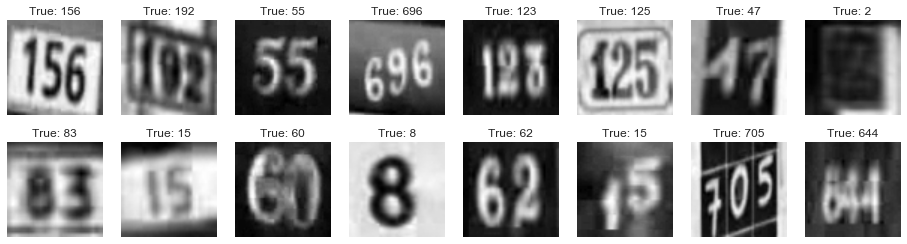

In [3]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(X_train, 2, 8, y_train)

### Helper functions for creating new variables

Functions for creating new [``TensorFlow Variables``](https://www.tensorflow.org/how_tos/variables/) in the given shape and initializing them using a [``clever initialization scheme``](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf)

In [4]:
def init_conv_weights(name, shape):
    """ Use initialization scheme proposed in Glorot et al.
    """
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def init_fc_weights(name, shape):
    """ Use initialization scheme proposed in Glorot et al.
    """
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def init_biases(shape):
    """ We simply use 0 to initialize the biases as it is most commonly used
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

### Helper function for stacking CONV-RELU layers followed by an optional POOL layer

This function creates a new convolutional layer in the computational graph for TensorFlow. The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point it is common to transition to fully connected layers.

In other words, the most common ConvNet archiecture follows the pattern:

```INPUT > [[CONV -> RELU]*N -> POOL?]M -> [FC -> RELU]*K -> FC```

The following helper function simplifies the creation of this pattern

In [5]:
def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):      # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # Create new filters with the given shape
    weights = init_conv_weights(layer_name, shape=shape)
    
    # Create new biases, one for each filter
    biases = init_biases(shape=[num_filters])

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='VALID')

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights

### Helper function for reshaping the CONV layers to FC layers

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer. E.g., if the input layer has the shape (?, 8, 8, 32) the flattened layer will have the shape (?, 8 x 8 x 32) or (?, 2048).

In [6]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

### Helper function for stacking FC-RELU layers

This function creates a new fully-connected layer in the computational graph for TensorFlow. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their activations can hence be computed with a matrix multiplication followed by a bias offset.

As mentioned in previous section most ConvNet architectures follows the following pattern:

```INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC```

The following helper function will simplify the process of stacking FC and RELU layers

In [7]:
def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = init_fc_weights(layer_name, [num_inputs, num_outputs])
    biases = init_biases([num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

### Helper function for creating a Softmax Classifier

The softmax classifier provides "probabilities" for each label. For example if if you have an image the softmax classifier will output the probability of each label e.g., [0.9, 0.09, 0.01] for the classes "0", "1" and "2", which allows us to interpret its confidence in each class. For our particular model we want to output multiple labels and we will therefore have 5 softmax classifiers operating on the same fully-connected layer, each with their individual weights and biases.

In [8]:
def softmax_classifier(input,      # Previous layer
                     weight_name,  # Name of variable containing the weights
                     num_inputs,   # Number of inputs from previous layer
                     num_outputs): # Number of outputs
                         
    # Create weights and biases
    weights = init_fc_weights(weight_name, [num_inputs, num_outputs])
    biases = init_biases([num_outputs])
    
    # Softmax
    logits = tf.matmul(input, weights) + biases
    
    return logits, weights

## Tensorflow Model

The configuration of the Convolutional Neural Network and data dimensions are defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [9]:
# Image size after cropping
img_size_cropped = 54

# Convolutional Layer 1
filter_size1 = 5          
num_filters1 = 16        

# Convolutional Layer 2
filter_size2 = 5          
num_filters2 = 32        

# Convolutional Layer 3
filter_size3 = 5          
num_filters3 = 64         

# Fully-connected layer
fc_size = 64            

### Placeholder Variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph

In [10]:
# Images placeholder
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')

# Labels placeholder
y_true = tf.placeholder(tf.int64, shape=[None, num_digits], name='y_true')

# To reduce overfitting we apply dropout
keep_prob = tf.placeholder(tf.float32)

### Pre-processing

The following helper functions helps us augment the data, and can be used in the TensorFlow computation graph to preprocess the input images. Data augmentation is used to apply some transformation to the input images without changing the labels and is widely used in practice.

In [ ]:
def pre_process_image(image, training=False):
    """ Use TensorFlow to apply random data augmentations during training
    """
    if training:
        # Randomly crop the input image
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0) 
        
    else:
        # Crop the image around the centre 
        image = tf.image.resize_image_with_crop_or_pad(image, img_size_cropped, img_size_cropped)
        
    return image


def pre_process_images(images, training=False):
    """ Use TensorFlow to loop over the images and preprocess them individually
    """
    return tf.map_fc(lambda: image: pre_process_image(image, training), images)


# Create pre-processing graph
#preprocessed_images = pre_process_images(images=x, training=True)

### Model

We implement the following ConvNet architecture:

```INPUT -> [CONV -> RELU -> POOL]*2 -> DROPOUT -> FC -> RELU -> OUTPUT LAYER```

In [2]:
# CONV -> RELU -> POOL
conv_1, w_c1 = conv_layer(x, "w_c1", num_channels, filter_size1, num_filters1, pooling=True)

# CONV -> RELU -> POOL
conv_2, w_c2 = conv_layer(conv_1, "w_c2", num_filters1, filter_size2, num_filters2, pooling=True)

# DROPOUT
dropout = tf.nn.dropout(conv_2, keep_prob)

# CONV -> FC conversions
flat, size = flatten_layer(dropout)

# FC -> RELU
fc_1 = fc_layer(flat, 'w_fc1', size, fc_size, relu=True)

# OUTPUT LAYER
logits_1, w_s1 = softmax_classifier(fc_1, 'w_s1', fc_size, num_labels)
logits_2, w_s2 = softmax_classifier(fc_1, 'w_s2', fc_size, num_labels)
logits_3, w_s3 = softmax_classifier(fc_1, 'w_s3', fc_size, num_labels)
logits_4, w_s4 = softmax_classifier(fc_1, 'w_s4', fc_size, num_labels)
logits_5, w_s5 = softmax_classifier(fc_1, 'w_s5', fc_size, num_labels)

y_pred = tf.pack([logits_1, logits_2, logits_3, logits_4, logits_5])

# The class-number is the index of the largest element
y_pred_cls = tf.transpose(tf.argmax(y_pred, dimension=2))

NameError: name 'conv_layer' is not defined

### Loss Function

The data loss takes the form of an average over the data losses for every individual example. The  ``tf.nn.softmax_cross_entropy_with_logits`` function computes the cross entropy of the result after applying the softmax function

In [13]:
# Calculate the loss for each individual digit in the sequence
loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, y_true[:, 0]))
loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, y_true[:, 1]))
loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, y_true[:, 2]))
loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, y_true[:, 3]))
loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, y_true[:, 4]))

# Calculate the total loss for all predictions
loss = loss1 + loss2 + loss3 + loss4 + loss5

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the [``AdamOptimizer``](https://www.tensorflow.org/api_docs/python/train/optimizers#AdamOptimizer) which is an advanced form of Gradient Descent. When training a model, it is often recommended to lower the learning rate as the training progresses. This function applies an exponential decay function to a provided initial learning rate.

In [14]:
# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0, trainable=False)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

### Evaluation Metric

To evaluate the performance of our Convolutional Network we calculate the average accuracy across all samples

In [15]:
''' TODO: Use TensorFlow to implement this!
'''
def accuracy(predictions, labels):
    return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

### Create TensorFlow Session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [16]:
session = tf.Session()

The variables for weights and biases must be initialized before we start optimizing them.

In [17]:
session.run(tf.initialize_all_variables())

## Optimization

There are many images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

In [18]:
# Batch size
batch_size = 64

# Number of steps between each update
display_step = 5

# Dropout
dropout = 0.9

The easiest way to save and restore a model is to use a tf.train.Saver object

In [19]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_multi')

#'''If you want to restore model'''
#saver.restore(sess=session, save_path=save_path)
#print("Model restored")

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [ ]:
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for step in range(num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every x iterations.
        if step % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_predictions = session.run(y_pred_cls, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, accuracy(batch_predictions, batch_labels)))
            
            # Calculate the accuracy on the validation-set
            val_predictions = session.run(y_pred_cls, {x: X_val, y_true: y_val, keep_prob: 1.})
            print("Validation accuracy: %.4f" % accuracy(val_predictions, y_val))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_diff = time.time() - start_time
    
    # Calculate the accuracy on the test-set
    test_predictions = session.run(y_pred_cls, {x: X_test, y_true: y_test, keep_prob: 1.})
    
    print("Test accuracy: %.4f" % accuracy(test_predictions, y_test))
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
    
    saver.save(sess=session, save_path=save_path)
    print('Model saved in file: {}'.format(save_path))

Let's run 100,000 iterations and see how well our model performs.

In [ ]:
optimize(num_iterations=100)

Minibatch accuracy at step 0: 56.5625


### Testset performance

Let's plot some of the mis-classified examples in our testset and a confusion matrix showing how well our model is able to predict the different digits.

In [ ]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, feed_dict={x: X_test, y_true: y_test, keep_prob: 1.0})

test_pred

#### Correctly classified images

Let's find some correctly classified examples and plot the true and predicted label values

In [ ]:
# Find the incorrectly classified examples
correct = np.array([(a==b).all() for a, b in zip(test_pred, y_test)])

# Select the incorrectly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);

#### Incorrectly classified images

Let's invert the boolean array and plot some of the incorrectly classified examples

In [ ]:
# Find the incorrectly classified examples
incorrect = np.invert(correct)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);

#### Digit sequence lengths impact on performance

Let's see how well our model is able to predict the label for different 

In [ ]:
# Close the session
session.close()